# Table des matières :
### * [Préparation des données](#first-bullet)
### * [Vérification et entrainement](#second-bullet)
### * [Préprocessing manuel](#third-bullet)
### * [Affichage resultats](#fourth-bullet)

## Préparation des données <a class="anchor" id="first-bullet"></a>


In [113]:
from fastai.vision.all import *
import fastai
import numpy as np
import os
import torchvision
from torchvision import transforms
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [114]:
torch.cuda.is_available()
torch.device('cpu')

device(type='cpu')

In [115]:
source = f'/home/remi/Documents/dataset_folder/DATASET'
#source = r'C:\Users\Remi\Pictures\DATASET-20210121T074943Z-001\DATASET'

df_marks = pd.DataFrame({'fname':['p0'], 'label':['oeuf'], 'is_valid':[True]})

#os.chdir(source)
for root, dirs, files in os.walk(source, topdown = False):
   for name in files:
      my_path = os.path.join(source, root, name)
      categorie = root.split("/")[7]
      #print(my_path)
      is_valid = False
      if r'\003\frigo' in root:
        is_valid = True
      new_row = {'fname':my_path[9+14:], 'label':categorie, 'is_valid':is_valid}
      df_marks = df_marks.append(new_row, ignore_index=True)
df_marks = df_marks[2:]

#print(df_marks)

In [116]:
top_10_list = [str(x) for x in df_marks.groupby('label').agg([ 'count']).reset_index().sort_values([('fname', 'count')], ascending=False)['label'][0:10]]
df_marks.groupby('label').agg([ 'count']).reset_index().sort_values([('fname', 'count')], ascending=False)

,label,fname,is_valid
,,count,count
5,beurre,114,114
33,oeufs,106,106
15,crème fraiche,50,50
24,fromage rapé,44,44
29,lait,36,36
50,yaourt,31,31
32,mayonnaise,31,31
38,pateFeuilletee,28,28
48,thon,26,26


In [117]:
from torchvision import models

In [118]:
obj2cat = {
    "thon":"conserve",
    
    "mayonnaise":"pot",
    "yaourt":"pot",
    "moutarde":"pot",
    
    "pateFeuilletee":"pate",
    "PateBrisee":"pate",
    
    "crème fraiche":"creme_ou_lait",
    "lait de vache":"creme_ou_lait",
    
    
    "oeufs":"oeuf",
    
    "chocolat noir":"cube_et_rectangle",
    
    "beurre":"beurre",
    "poulet":"cube_et_rectangle",
    "saussice":"cube_et_rectangle",
    
    "Fromage rapé":"fromage",
    "fromage comté":"fromage",
    
    "salade":"legume",
    "oranges":"legume",
    "peche":"legume",
    "poireau":"legume"    
}

In [119]:
files = get_image_files(source)
files = [f for f in files]

In [120]:
set_list = []
for f in files:
    for top in obj2cat.keys():
        #print(f,top)
        if top in str(f):
            set_list.append(f)

In [121]:
def label_func(f): 
    #print(f)
    categorie = str(f).split("/")[7]#.replace(" ","_")
    return obj2cat[categorie]

In [122]:
idx_val = ["/000/" in str(x) for x in set_list]

def RandomSplitterRemi(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        rand_idx = L(int(i) for i in range(len(set_list)))
        return  rand_idx[[i==False for i in idx_val]], rand_idx[idx_val]
    return _inner

# Vérification et entrainement <a class="anchor" id="second-bullet"></a>

In [123]:
auf = aug_transforms(size=128*3,
                                             mult=1.0, 
                                             do_flip=True, 
                                             flip_vert=False, 
                                             max_rotate=10.0, 
                                             min_zoom=1.0, 
                                             max_zoom=1.1, 
                                             max_lighting=0.1, #0.2
                                             max_warp=0.2, 
                                             p_affine=0.75, 
                                             p_lighting=1.0, #0.75
                                             xtra_tfms=None,
                                             mode='bilinear', 
                                             pad_mode='reflection', 
                                             align_corners=True, 
                                             batch=False, 
                                             min_scale=1.0
                                            
                  )

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   #get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(128*4),
                   batch_tfms= None)#,do_flip=False))

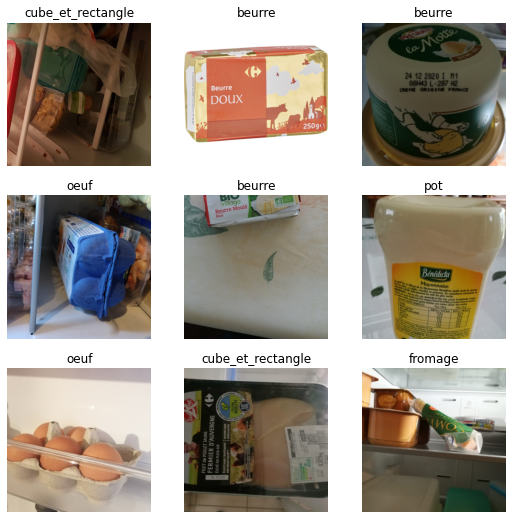

In [124]:
dls = dblock.dataloaders(set_list, bs=16)
dls.show_batch()

In [125]:
len(dls.train), len(dls.valid)

(25, 7)

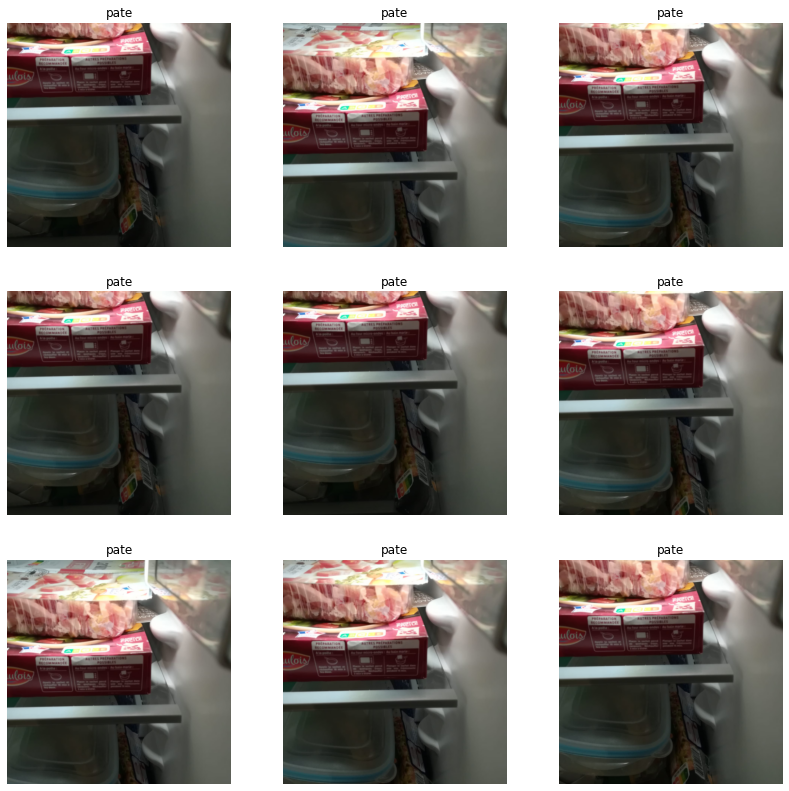

In [126]:
dls.show_batch(unique=True,figsize=(14,14))

In [127]:
def top_2_accuracy(inp, targ, k=5, axis=-1):
    return top_k_accuracy(inp, targ, k=2, axis=-1)

In [128]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy,error_rate,top_2_accuracy], cbs=SaveModelCallback())

In [129]:
#learn.model
train=False
if train:
    learn.lr_find()

In [130]:
if train:
    import cProfile
    Pr=cProfile.Profile()
    Pr.enable()

    learn.fine_tune(15,   base_lr=0.01)

    Pr.disable()
    Pr.print_stats('time')

In [131]:
learn.dls.vocab

['beurre', 'conserve', 'creme_ou_lait', 'cube_et_rectangle', 'fromage', 'legume', 'oeuf', 'pate', 'pot']

# Préprocessing manuel <a class="anchor" id="third-bullet"></a>


In [132]:
from PIL import Image

source="inputs_data/beurreCarre.jpg"
im = Image.open(source)

In [133]:
#learn.dls[0].__dict__

In [134]:
arr = np.asarray(im)
im3 = Image.fromarray(arr, 'RGB')
type(im3)

PIL.Image.Image

In [135]:
t = torch.tensor(arr).permute(2,0,1)
t = torchvision.transforms.Resize(128*4)(t)
t = t/255.0
#t = torchvision.transforms.Resize(128*3)(t)
#t = torchvision.transforms.Resize(128*3)(t)
t.shape

torch.Size([3, 512, 512])

In [136]:
regular_tf = transforms.Compose([ transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                                     std = [ 0.229, 0.224,0.225 ])])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),])

t = regular_tf(t) 

# importing models

In [137]:
learn.load("model")

/home/remi/anaconda3/envs/fastaiv2/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [138]:
m = learn.model.cpu().eval()

In [139]:
example_inputs = torch.rand(1, 3, 224, 224)
resnet18_traced = torch.jit.trace(m, example_inputs = example_inputs)
#resnet18_traced.save("resnet18_traced_fai.pt")

# Affichage resultats <a class="anchor" id="fourth-bullet"></a>

In [140]:
#learn.get_preds()[0].shape

dl = learn.dls.test_dl([source], rm_type_tfms=None, num_workers=0)
#dl.after_batch.fs[2]=Brightness(max_lighting=0.0, p=1, draw=None, batch=False)

inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
inp.sum(), preds

(TensorImage(505935.),
 tensor([[4.4474e-01, 1.9504e-04, 5.5067e-03, 2.6537e-03, 1.9383e-02, 6.3538e-03,
          3.1940e-01, 1.9853e-01, 3.2476e-03]]))

In [141]:
dl.after_item

Pipeline: Resize -- {'size': (512, 512), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [142]:
dl.before_batch.fs

(#0) []

In [143]:
dl.after_batch.fs

(#2) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
decodes: (TensorImage,object) -> decodes
]

In [144]:
#dl.after_batch.fs[2].p=0.0
#dl.after_batch.fs[2].max_lighting = 0.001
#dl.after_batch.fs[2]
#type(dl.after_batch.fs[2])

In [145]:
#fastai.vision.augment.Brightness(p=0.0)

In [146]:
#dl.__dict__

In [147]:
inv_tensor = invTrans(inp)
inv_tensor_good_shape = torch.squeeze(inv_tensor, dim=0).permute(1,2,0)#.shape
inv_tensor_good_shape.shape

torch.Size([512, 512, 3])

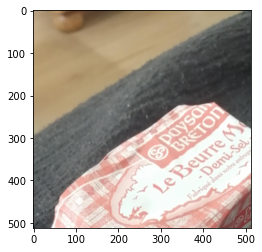

In [148]:
plt.imshow(inv_tensor_good_shape)

In [149]:
m2 = resnet18()

In [150]:
##trash

diff = inp - t
diff.mean(), diff.std()

(TensorImage(0.0067), TensorImage(0.0409))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


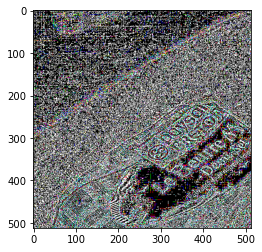

In [151]:
plt.imshow(diff.squeeze(0).permute(1, 2, 0)*255)

In [152]:
_ = resnet18_traced.cpu()

In [153]:
torch.nn.Softmax(dim=1)(resnet18_traced(t.unsqueeze(0)))

tensor([[7.4887e-01, 2.1289e-04, 1.1269e-02, 2.0338e-03, 1.2764e-02, 4.0475e-03,
         1.7393e-01, 4.3162e-02, 3.7169e-03]], grad_fn=<SoftmaxBackward>)

In [154]:
learn.cpu()
torch.nn.Softmax(dim=1)(learn.model(t.unsqueeze(0)))

tensor([[7.4887e-01, 2.1289e-04, 1.1269e-02, 2.0338e-03, 1.2764e-02, 4.0475e-03,
         1.7393e-01, 4.3162e-02, 3.7169e-03]], grad_fn=<SoftmaxBackward>)

In [155]:
#original
learn.predict("/home/remi/Documents/testimg/beurreCarre.jpg")

('beurre',
 tensor(0),
 tensor([4.4474e-01, 1.9504e-04, 5.5067e-03, 2.6537e-03, 1.9383e-02, 6.3538e-03,
         3.1940e-01, 1.9853e-01, 3.2476e-03]))

In [156]:
arr.shape

(1600, 1600, 3)

In [157]:
t.shape

torch.Size([3, 512, 512])